In [87]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import numpy as np
from glob import glob
from datasets.dataset_generic_npy import Generic_MIL_Dataset

In [92]:
data = np.load("/home3/gzy/Camelyon/feature/test_001_0_256.npy",allow_pickle=True)[()]

In [65]:
from __future__ import print_function, division
import os
import torch
import numpy as np
import pandas as pd
import math
import re
import pdb
import pickle
import cv2

from torch.utils.data import Dataset, DataLoader, sampler
from torchvision import transforms, utils, models
import torch.nn.functional as F

from PIL import Image
import h5py

from random import randrange
import openslide


# name

with h5py.File("/home1/gzy/Nature/CLAM/test/patches/test_001.h5",'r') as hdf5_file:
    coord = hdf5_file['coords'][0]
name='test_001'
anno_path = '/home3/gzy/Camelyon/annotation/summary/' + dict1[name+'.tif'] + '.png'
#     coord = hdf5_file['coords'].attrs['name']
# img = self.wsi.read_region(coord, self.patch_level, (self.patch_size, self.patch_size)).convert('RGB')
        
# 
# 

# h,w = self.wsi.level_dimensions[1]
# mask_h,mask_w = 

In [66]:
wsi_path = '/home6/svs_files/'+dict1[name+'.tif']+'/'+name+'.tif'

In [67]:
wsi = openslide.OpenSlide(wsi_path)

In [82]:
h,w = wsi.level_dimensions[1]
cancer_mask = cv2.imread(anno_path)
cancer_mask = cv2.cvtColor(cancer_mask, cv2.COLOR_BGR2RGB)
cancer_mask_binary = np.zeros(cancer_mask.shape[:-1])
cancer_mask_binary[(cancer_mask!=[0,0,0]).any(axis=-1)] = 1
cancer_mask_binary=cancer_mask_binary.T
mask_h,mask_w = cancer_mask_binary.shape
mag = int(w/mask_w)

In [85]:
h,w

(43008, 45056)

In [84]:
mask_h,mask_w

(2688, 2800)

In [76]:
89600//2800

32

In [86]:
coord

array([37240, 69565])

In [60]:
cancer_mask_binary.size

7526400

In [45]:
np.count_nonzero(cancer_mask_binary)

96693

In [44]:
mag

16

In [54]:
cancer_mask_binary[0:32,0:7700].size

89600

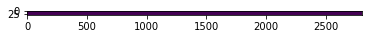

In [50]:
from matplotlib import pyplot as plt
plt.imshow(cancer_mask_binary[0:32,0:7000])

In [26]:
cancer_mask.shape

(2800, 2688, 3)

In [15]:
coord

'test_001'

In [2]:
dataset = Generic_MIL_Dataset(csv_path = 'dataset_csv/renal_subtyping_npy.csv',
                            data_dir= '/home3/gzy/Renal/feature_e_b0/',
                            data_mag = '1_512',
                            shuffle = False, 
                            seed = 10, 
                            print_info = True,
                            label_dict = {'ccrcc':0, 'prcc':1, 'chrcc':2},
                            patient_strat= False,
                            ignore=[])

label column: label
label dictionary: {'ccrcc': 0, 'prcc': 1, 'chrcc': 2}
number of classes: 3
slide-level counts:  
 0    299
1    258
2    103
Name: label, dtype: int64
Patient-LVL; Number of samples registered in class 0: 299
Slide-LVL; Number of samples registered in class 0: 299
Patient-LVL; Number of samples registered in class 1: 258
Slide-LVL; Number of samples registered in class 1: 258
Patient-LVL; Number of samples registered in class 2: 103
Slide-LVL; Number of samples registered in class 2: 103


In [3]:
train_split, val_split, test_split = dataset.return_splits(from_id=False, 
                csv_path='{}/splits_{}.csv'.format('./splits/renal_subtype_100/', 0))

In [4]:
for i in range(len(train_split)):
    print(train_split[i][0].shape)

torch.Size([87, 1280])
torch.Size([792, 1280])
torch.Size([1095, 1280])
torch.Size([679, 1280])
torch.Size([445, 1280])
torch.Size([210, 1280])
torch.Size([977, 1280])
torch.Size([622, 1280])
torch.Size([347, 1280])
torch.Size([180, 1280])
torch.Size([772, 1280])
torch.Size([696, 1280])
torch.Size([811, 1280])
torch.Size([1096, 1280])
torch.Size([524, 1280])
torch.Size([884, 1280])
torch.Size([119, 1280])
torch.Size([728, 1280])
torch.Size([697, 1280])
torch.Size([500, 1280])
torch.Size([1646, 1280])
torch.Size([353, 1280])
torch.Size([58, 1280])
torch.Size([1152, 1280])
torch.Size([757, 1280])
torch.Size([264, 1280])
torch.Size([746, 1280])
torch.Size([782, 1280])
torch.Size([1022, 1280])
torch.Size([639, 1280])
torch.Size([102, 1280])
torch.Size([382, 1280])
torch.Size([1104, 1280])
torch.Size([1967, 1280])
torch.Size([969, 1280])
torch.Size([184, 1280])
torch.Size([133, 1280])
torch.Size([707, 1280])
torch.Size([1128, 1280])
torch.Size([591, 1280])
torch.Size([1164, 1280])
torch.Siz

KeyboardInterrupt: 

In [4]:
## CUDA_VISIBLE_DEVICES=0 python main.py --drop_out --early_stopping --lr 2e-4 --k 5 --label_frac 1.0 --exp_code task_2_tumor_subtyping_CLAM_50 --weighted_sample --bag_loss ce --inst_loss svm --task renal_subtype --model_type clam_mb --log_data --subtyping --data_root_dir /home3/gzy/

In [4]:
import numpy as np
import torch
from utils.utils import *
from datasets.dataset_generic import save_splits
from models.model_mil import MIL_fc, MIL_fc_mc
from models.model_clam import CLAM_MB, CLAM_SB, WSOD
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import auc as calc_auc

In [5]:
model_dict = {"dropout": True, 'n_classes': 3}
model_dict.update({"size_arg": 'small'})
model_dict.update({'subtyping': True})
loss_fn = nn.CrossEntropyLoss()

train_loader = get_split_loader(train_split, training=True)

model = WSOD(**model_dict)
model = model.cuda()

In [6]:
for batch_idx, (data, label, cors, inst_label) in enumerate(train_loader):
        data, label = data.to(device), label.to(device)
        mask = cors[0][1]
        final_score, Y_prob, Y_hat, det_score, results_dict = model(data, mask)
        break

In [11]:
f_h, f_w = np.where(mask==1)

In [12]:
cls_final_score = final_score[:,0]
cls_final_score = (cls_final_score-cls_final_score.min())/(cls_final_score.max()-cls_final_score.min())
tp_score, tp_index = torch.topk(cls_final_score, int(len(cls_final_score)*0.1))

In [60]:
cors = np.array([f_h,f_w]).T
tp_cors = cors[tp_index.cpu()]

In [82]:
nb_mask = np.zeros_like(mask)
for index in tp_index:
    x_index, y_index = f_h[index], f_w[index]
    nb_mask[max(0,x_index-1):x_index+2, max(0,y_index-1):y_index+2] = 1
nb_mask = nb_mask * mask

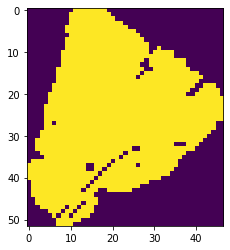

In [12]:
from matplotlib import pyplot as plt
plt.imshow(cors[1])

In [26]:
from torch.nn import functional as F

wsi_label = torch.zeros(3)
wsi_label[label.long()] = 1
wsi_label = wsi_label.cuda()

F.binary_cross_entropy(Y_prob, wsi_label)

tensor(0.6322, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

In [30]:
wsi_label = torch.zeros(3)
wsi_label[[0,1]] = 1

In [31]:
wsi_label

tensor([1., 1., 0.])